## Neural Network

In [202]:
import torch
import torch.nn as nn
from sklearn.datasets import make_blobs

import numpy as np
import matplotlib.pylab as plt

In [170]:
# ReLU

class Relu:

  def evaluate(self, x):
    return nn.ReLU(x)
  
  def gradient(self, x):
    return x.apply_(lambda t: 1 if t > 0 else 0)


In [171]:
# sigmoid

class Sigmoid:

  def evaluate(self, x):
    return torch.sigmoid(x)
  
  def gradient(self, x):
    return torch.sigmoid(x) * (torch.ones_like(x) - torch.sigmoid(x))

In [172]:
"""
  # The NeuralNetwork class is supposed to work as follows.
  # We can define a network, i.e., with 2 input, 3 hidden, and 1 output neurons as
  net = NeuralNetwork([2,3,1])
  # A forward pass (prediction) can be computed using
  net.forward(x)
  # and the gradients of all parameters can be obtained via
  net.backprop(x, y)
  # Finally, the network can be trained by calling
  net.train(x, y)
  # Other activation functions can be provided when creating the object:
  net = NeuralNetwork([2,3,1], activations=[ReLU(), ReLU(), sigmoid()])
"""

class NeuralNetwork:
  
  def __init__(self, neurons_per_layer, activations=None):
    # neurons per layer (incl. input and output)
    self.neurons_per_layer = np.array(neurons_per_layer)
    # list holding the weight matrices
    self.weight = []
    # list holding the bias vectors
    self.bias = []
    # list holding the activation functions
    self.activation = []
    # intermediate states of s(they get set by each forward pass)
    self._s = []
    # intermediate states of x(they get set by each forward pass)
    self._x = []

    for d_in, d_out in zip(neurons_per_layer[:-1], neurons_per_layer[1:]):
      
      # initializing the weights through a normal distribution
      self.weight.append( torch.normal(mean=0, std=np.sqrt(2/(d_in + d_out)), size=(d_out, d_in) ) )
      # initializing biases as zero
      self.bias.append( torch.zeros((d_out, 1)) )

    for d in neurons_per_layer[1:]:
      self._s.append(np.zeros((d,1)))
    for d in neurons_per_layer:
      self._x.append(np.zeros((d,1)))

    if activations==None:
      # if no activations list is given, use sigmoid() as default
      for _ in range(len(neurons_per_layer)-1):
        self.activation.append(Sigmoid())
    else:
      self.activation = activations


  def forward(self, x):
    self._x[0] = x
    for i in range(len(self.neurons_per_layer) - 1):
      self._s[i] = torch.matmul(self.weight[i], self._x[i]) + self.bias[i]
      self._x[i+1] = self.activation[i].evaluate(self._s[i])
    # also set the intermediate states _x and _s
    return self._x[-1]


  def mean_squared_loss(self, y_prediction, y):
    return torch.mean(torch.square(y_prediction - y))


  # x and y being the inputs and expected outputs
  # return gradients of weight and bias variables
  def backprop(self, x, y):

    # forward pass
    xl = self.forward(x)
    # gradients for w, b & s (same), and x
    wgs, bgs, xgs = [], [], []

    # derivative of sqaured loss function
    xgs.append( torch.mean(2 * (xl - y), dim=1, keepdim=True) )

    # average out all the s & x values for from forward pass for gradient calculation
    for i in range(len(self._s)):
      self._s[i] = torch.mean(self._s[i], dim=1, keepdim=True)

    for i in range(len(self._x)):
      self._x[i] = torch.mean(self._x[i], dim=1, keepdim=True)

    # beginning from the final layer
    n = len(self.neurons_per_layer)
    for i in range(n - 1):
      act_func = self.activation[n-i-2]
      bgs.append(xgs[i] * act_func.gradient(self._s[n-i-2]))
      wgs.append(torch.matmul(bgs[i], self._x[n-i-2].T))
      xgs.append(torch.matmul(self.weight[n-i-2].T, bgs[i]))

    wgs.reverse()
    bgs.reverse()
    return wgs, bgs


  # x and y being the inputs and expected outputs
  # return final weights and biases
  def train(self, x, y, eta=.01, max_iter=100, batch_size=50):

    obs = x.shape[0] # of data observations
    trained = 0
    iter = 0
    log_iter = max_iter // 20

    while iter < max_iter:
      # random batch draw
      batch_idxs = torch.randint(high=obs, size=(batch_size, ))
      # backpropagation
      wgs, bgs = self.backprop(x[batch_idxs].T, y[batch_idxs].T)
      
      for j in range(len(self.weight)):
        self.weight[j] -= eta * wgs[j]
        self.bias[j] -= eta * bgs[j]
      
      # loss
      loss = self.mean_squared_loss(self.forward(x[batch_idxs].T), y[batch_idxs].T)
      trained += batch_size
      iter += 1
      if iter % log_iter == 0 or iter >= max_iter:
        print(f"Observations: {trained}, loss: {loss}")

    return wgs, bgs

In [173]:
# Run NN

net = NeuralNetwork([2,3,2])

# set the weights and biases
net.weight[0] = torch.tensor([[.2, -.3], [.1, -1.2], [.4, .3]])
net.bias[0] = torch.tensor([[.3], [-.1], [1.2]])
net.weight[1] = torch.tensor([[0.4, 0.2, 0.2], [0.1, 0.3, 0.5]])
net.bias[1] = torch.tensor([[-.6], [.5]])

# set the input
x0 = torch.tensor([[1.], [2.]])
# compute the forward pass
net.forward(x0)
# compare the intermediate states
net._s[0], net._x[1], net._s[1], net._x[2]

(tensor([[-0.1000],
         [-2.4000],
         [ 2.2000]]),
 tensor([[0.4750],
         [0.0832],
         [0.9002]]),
 tensor([[-0.2133],
         [ 1.0226]]),
 tensor([[0.4469],
         [0.7355]]))

In [174]:
# compute backpropagation differentials

y = torch.tensor([[0.], [1.]])
wgs, bgs = net.backprop(x0, y)
wgs[0], bgs[0], wgs[1], bgs[1]

(tensor([[ 0.0195,  0.0389],
         [ 0.0010,  0.0020],
         [-0.0007, -0.0013]]),
 tensor([[ 0.0195],
         [ 0.0010],
         [-0.0007]]),
 tensor([[ 0.1049,  0.0184,  0.1989],
         [-0.0489, -0.0086, -0.0927]]),
 tensor([[ 0.2209],
         [-0.1029]]))

In [175]:
# training with toy dataset

rx, ry = make_blobs(n_samples=10000, centers=2, n_features=4, random_state=1)
rx = torch.from_numpy(rx).type(torch.FloatTensor)
ry = torch.from_numpy(ry).reshape((-1, 1))
rx.shape, ry.shape, rx[0], ry[:4]

(torch.Size([10000, 4]),
 torch.Size([10000, 1]),
 tensor([-6.7942, -9.7594, -6.8150, -2.3030]),
 tensor([[1],
         [0],
         [0],
         [1]]))

In [176]:
rnet = NeuralNetwork(neurons_per_layer=[4, 3, 1])
fws, fbs = rnet.train(rx, ry, eta=0.005, max_iter=1000, batch_size=512)
print(f"Final weights: {fws}\nFinal biases: {fbs}")

Observations: 25600, loss: 0.2671912610530853
Observations: 51200, loss: 0.25937268137931824
Observations: 76800, loss: 0.26260116696357727
Observations: 102400, loss: 0.2608714997768402
Observations: 128000, loss: 0.25648459792137146
Observations: 153600, loss: 0.2538619637489319
Observations: 179200, loss: 0.26227229833602905
Observations: 204800, loss: 0.25651103258132935
Observations: 230400, loss: 0.25910815596580505
Observations: 256000, loss: 0.2529973089694977
Observations: 281600, loss: 0.2589014768600464
Observations: 307200, loss: 0.26020780205726624
Observations: 332800, loss: 0.256300687789917
Observations: 358400, loss: 0.2510022222995758
Observations: 384000, loss: 0.25515449047088623
Observations: 409600, loss: 0.2521864175796509
Observations: 435200, loss: 0.252912700176239
Observations: 460800, loss: 0.25295737385749817
Observations: 486400, loss: 0.25098085403442383
Observations: 512000, loss: 0.2532513737678528
Final weights: [tensor([[-4.6129e-05, -2.1472e-05, -8.4

### MNIST

In [177]:
import torchvision

In [178]:
mnist = torchvision.datasets.MNIST('./data', download=True)
dx = mnist.data
dy = mnist.targets

In [179]:
# convert to 6 vs. 9 problem

ids6n9 = ((dy == 6) | (dy == 9))
nx = dx[ids6n9]
ny = dy[ids6n9]
ny[ny==6] = 0
ny[ny==9] = 1
nx = nx.reshape((nx.shape[0], -1))

nx = nx.type(torch.FloatTensor)
ny = ny.type(torch.FloatTensor)

dx.shape, dy.shape, nx.shape, ny.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([11867, 784]),
 torch.Size([11867]))

In [199]:
# neural network train & test

net6n9 = NeuralNetwork([784, 196, 1])
w6n9, b6n9 = net6n9.train(nx, ny, eta=5e-4, max_iter=5000, batch_size=512)
print(f"Final weights: {w6n9}\nFinal biases: {b6n9}")

Observations: 128000, loss: 0.24158532917499542
Observations: 256000, loss: 0.23099613189697266
Observations: 384000, loss: 0.2303016185760498
Observations: 512000, loss: 0.23186351358890533
Observations: 640000, loss: 0.2411385327577591
Observations: 768000, loss: 0.24139247834682465
Observations: 896000, loss: 0.23022334277629852
Observations: 1024000, loss: 0.23070012032985687
Observations: 1152000, loss: 0.2264096736907959
Observations: 1280000, loss: 0.22868169844150543
Observations: 1408000, loss: 0.22553658485412598
Observations: 1536000, loss: 0.2384493201971054
Observations: 1664000, loss: 0.2298441082239151
Observations: 1792000, loss: 0.2305794656276703
Observations: 1920000, loss: 0.23551364243030548
Observations: 2048000, loss: 0.2300243377685547
Observations: 2176000, loss: 0.22692839801311493
Observations: 2304000, loss: 0.22911150753498077
Observations: 2432000, loss: 0.22259360551834106
Observations: 2560000, loss: 0.22637367248535156
Final weights: [tensor([[0., 0., 0

In [200]:
# training accuracy

preds = net6n9.forward(nx.T).reshape(-1)
print(preds.shape, min(preds), max(preds))

preds[preds <= 0.5] = -1
preds[preds > 0.5] = 1
preds.unique()

torch.Size([11867]) tensor(0.0940) tensor(0.9007)


tensor([-1.,  1.])

In [201]:
from sklearn.metrics import accuracy_score

accuracy_score(ny.numpy(), preds.numpy())

0.3134743406084099

## Approximation

In [576]:
# we try to approximate the sine function
def f(x):
  return np.sin(x)

In [577]:
# number of functions
n = 5
# beginning the the interval
a = 0
# end the the interval
b = 6
# beginning the the interval
x = np.linspace(a, b, n)
# spacing
h = x[1]-x[0]
# biases
b_ = [a + (j-2)*h for j in range(1, n+1)]
# function values come from current and functions preceding it
f_ = [f(xe) for xe in x]

x, h, b_, f_

(array([0. , 1.5, 3. , 4.5, 6. ]),
 1.5,
 [-1.5, 0.0, 1.5, 3.0, 4.5],
 [0.0,
  0.9974949866040544,
  0.1411200080598672,
  -0.977530117665097,
  -0.27941549819892586])

In [578]:
# matrix used in the linear system of equations
cols = []
for i in range(1, n):
  t = torch.arange(start=1, end=i+1).reshape((i, 1))
  t = torch.cat( (torch.zeros((n-i, 1)), t), dim=0 )
  cols.insert(0, t)

cols.insert(0, torch.arange(start=1, end=n+1).reshape((n, 1)))
A = torch.cat(cols, dim=1)
A

tensor([[1., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0.],
        [3., 2., 1., 0., 0.],
        [4., 3., 2., 1., 0.],
        [5., 4., 3., 2., 1.]])

In [579]:
# fit parameters lambda
lambda_ = np.linalg.solve(A, f_)
lambda_

array([-2.66453526e-16,  9.97494987e-01, -1.85386997e+00, -2.62275147e-01,
        1.81676475e+00])

In [580]:
# defining approximations with coefficients lambda
def approx(x):
  # each function is only influenced by the preceding functions
  r = 0
  for be, le in zip(b_, lambda_):
    r += le * max(0, x - be)
  return r

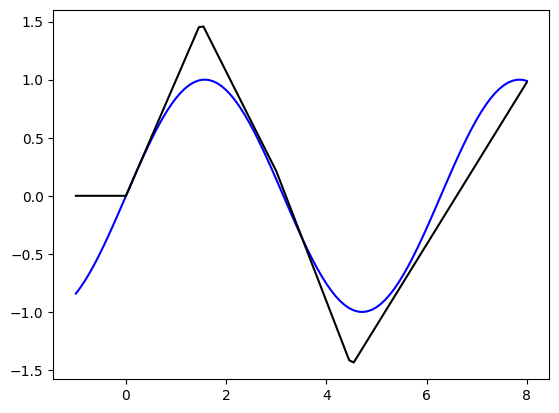

In [581]:
# plot the function and the approximation
dom = np.linspace(-1,8,100)
fig, ax = plt.subplots()
ax.plot(dom, [f(d) for d in dom], 'b-')
ax.plot(dom, [approx(d) for d in dom] , 'k-')